In [1]:
import orchest
from dask.distributed import Client

In [2]:
cluster_credentials = orchest.get_inputs()["cluster_credentials"]

In [3]:
cluster_credentials['address'], cluster_credentials['security']

('tls://3.235.247.64:8786', GatewaySecurity<...>)

In [4]:
client = Client(cluster_credentials['address'], security=cluster_credentials['security'])
print('Dashboard:', client.dashboard_link)

Dashboard: http://3.235.247.64:8787/status


/opt/conda/lib/python3.7/site-packages/distributed/client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+---------------+----------------+----------------+
| Package | client        | scheduler      | workers        |
+---------+---------------+----------------+----------------+
| numpy   | 1.21.5        | 1.20.3         | 1.20.3         |
| python  | 3.7.6.final.0 | 3.7.11.final.0 | 3.7.11.final.0 |
+---------+---------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client.ncores()

{'tls://10.4.10.235:42833': 2,
 'tls://10.4.13.108:43681': 2,
 'tls://10.4.15.142:37575': 2}

In [6]:
import dask.dataframe as dd

# Load the entire dataset using Dask
ddf = dd.read_csv("s3://coiled-data/higgs/higgs-*.csv", storage_options={"anon": True})
ddf

,labels,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b-tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
npartitions=126,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
from dask_ml.model_selection import train_test_split

X, y = ddf.iloc[:, 1:], ddf["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

In [8]:
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import dask

X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

X_train

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b-tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
npartitions=126,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
import dask_xgboost

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'min_child_weight': 0.5,
}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=3)

/opt/conda/lib/python3.7/site-packages/dask_xgboost/__init__.py:8: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  "Dask-XGBoost has been deprecated and is no longer maintained. The functionality "


In [11]:
y_pred = dask_xgboost.predict(client, bst, X_test)
y_test, y_pred = dask.compute(y_test, y_pred)

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

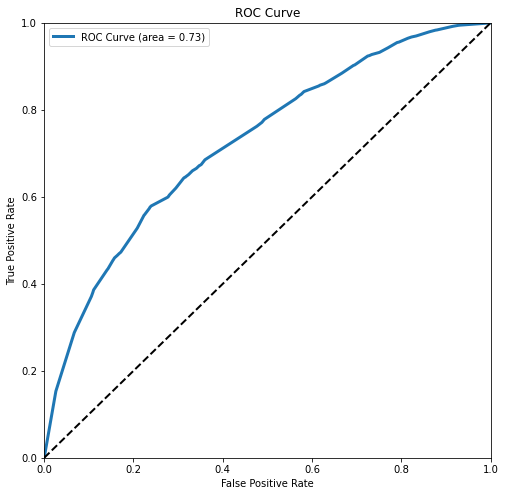

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], "k--", lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()